# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

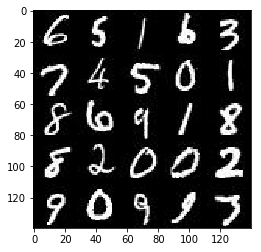

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

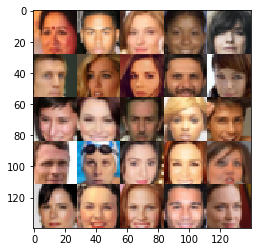

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image = tf.placeholder(tf.float32,[None, image_width, image_height, image_channels],name='input_real')
    Z = tf.placeholder(tf.float32, [None, z_dim],name='input_z')
    l_rate = tf.placeholder(tf.float32)

    return image, Z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [77]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        images = tf.layers.dropout(images, rate=0.6)
        # input image is 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=1,padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.layers.dropout(relu1, rate=0.6)
        # 28*28*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=0.6)
        # 14*14*256
         
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=0.6)
        # 7*7*256
               
        # dropout
        dropout = tf.nn.dropout(relu3, 0.6)
        
        #leaky Relu
        flat = tf.reshape(dropout, (-1, 7*7*256))
        logits = tf.layers.dense(flat,1,activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [84]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
               
        x4 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x128
        
        x5 = tf.layers.conv2d_transpose(x4, 64, 5, strides=1, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        # 14x14x64
        
                

        # Output layer
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        
        out = tf.tanh(logits)
        
        return out 
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [85]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    # Smoothing 
    smooth = 0.8
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)) * (1 - smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [86]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [87]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [88]:
import sklearn.preprocessing
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    class GAN:
        def __init__(self, data_shape, z_dim, learning_rate):
        
            self.input_real, self.input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              data_shape[3])
        
            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
    

    net = GAN(data_shape, z_dim, learning_rate)

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                #print(batch_images.shape)
                
                # normalize
                batch_images = batch_images*2
                    
                
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    

                if steps % 100 == 0:
                    show_generator_output(sess, 25, net.input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 1.0644
Epoch 1/2... Discriminator Loss: 0.8545... Generator Loss: 1.4760
Epoch 1/2... Discriminator Loss: 0.5970... Generator Loss: 2.0463
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 0.9818
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 1.3403
Epoch 1/2... Discriminator Loss: 0.4397... Generator Loss: 2.1164
Epoch 1/2... Discriminator Loss: 0.4792... Generator Loss: 2.4264
Epoch 1/2... Discriminator Loss: 0.4935... Generator Loss: 1.5640
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 6.4042


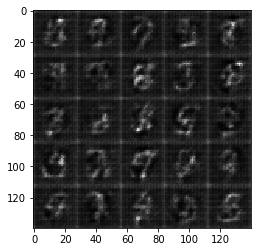

Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 1.2096
Epoch 1/2... Discriminator Loss: 0.4520... Generator Loss: 1.9751
Epoch 1/2... Discriminator Loss: 0.4318... Generator Loss: 1.9571
Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 1.3946
Epoch 1/2... Discriminator Loss: 0.3549... Generator Loss: 2.2400
Epoch 1/2... Discriminator Loss: 0.3648... Generator Loss: 1.9120
Epoch 1/2... Discriminator Loss: 0.3685... Generator Loss: 2.2965
Epoch 1/2... Discriminator Loss: 0.3939... Generator Loss: 3.5484
Epoch 1/2... Discriminator Loss: 0.2985... Generator Loss: 2.8918
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.0457


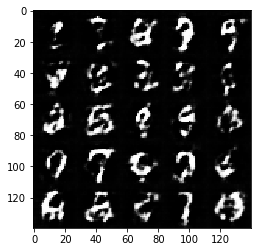

Epoch 1/2... Discriminator Loss: 0.3550... Generator Loss: 2.4921
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 1.8247
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 1.5729
Epoch 1/2... Discriminator Loss: 0.2569... Generator Loss: 2.8946
Epoch 1/2... Discriminator Loss: 0.6727... Generator Loss: 1.0355
Epoch 1/2... Discriminator Loss: 0.5160... Generator Loss: 1.4312
Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 0.9405
Epoch 1/2... Discriminator Loss: 0.5695... Generator Loss: 1.3848
Epoch 1/2... Discriminator Loss: 0.7299... Generator Loss: 1.0328
Epoch 1/2... Discriminator Loss: 0.8267... Generator Loss: 0.9413


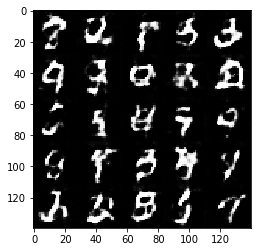

Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 1.0116
Epoch 1/2... Discriminator Loss: 0.4535... Generator Loss: 1.9480
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 0.6825
Epoch 1/2... Discriminator Loss: 0.4360... Generator Loss: 2.4514
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 0.7367... Generator Loss: 1.3837
Epoch 1/2... Discriminator Loss: 0.4659... Generator Loss: 1.6395
Epoch 1/2... Discriminator Loss: 0.5398... Generator Loss: 1.7029
Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 0.9638


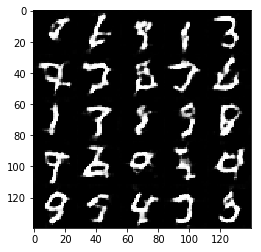

Epoch 1/2... Discriminator Loss: 0.4479... Generator Loss: 1.6983
Epoch 1/2... Discriminator Loss: 0.5121... Generator Loss: 3.1228
Epoch 1/2... Discriminator Loss: 0.5302... Generator Loss: 2.0985
Epoch 1/2... Discriminator Loss: 0.6207... Generator Loss: 1.2593
Epoch 1/2... Discriminator Loss: 0.4244... Generator Loss: 2.0078
Epoch 1/2... Discriminator Loss: 0.5011... Generator Loss: 1.4878
Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 2.4322
Epoch 1/2... Discriminator Loss: 0.3689... Generator Loss: 2.6281
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 1.8650
Epoch 1/2... Discriminator Loss: 0.3979... Generator Loss: 1.7175


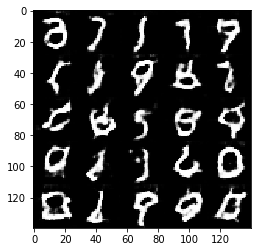

Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 0.5757... Generator Loss: 1.2679
Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 1.9847
Epoch 1/2... Discriminator Loss: 0.9203... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 0.5335... Generator Loss: 1.3985
Epoch 1/2... Discriminator Loss: 0.4516... Generator Loss: 1.8317
Epoch 1/2... Discriminator Loss: 0.5283... Generator Loss: 1.2780
Epoch 1/2... Discriminator Loss: 0.6910... Generator Loss: 1.0758
Epoch 1/2... Discriminator Loss: 0.4597... Generator Loss: 1.4685
Epoch 1/2... Discriminator Loss: 0.4011... Generator Loss: 3.1583


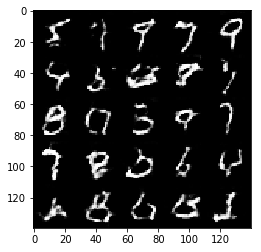

Epoch 1/2... Discriminator Loss: 0.6306... Generator Loss: 1.2214
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 4.7161
Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 1.4576
Epoch 1/2... Discriminator Loss: 0.4751... Generator Loss: 1.4067
Epoch 1/2... Discriminator Loss: 0.3716... Generator Loss: 1.8077
Epoch 1/2... Discriminator Loss: 0.6641... Generator Loss: 1.1541
Epoch 1/2... Discriminator Loss: 0.6464... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.4757
Epoch 1/2... Discriminator Loss: 0.8588... Generator Loss: 0.8964
Epoch 1/2... Discriminator Loss: 0.4240... Generator Loss: 1.6013


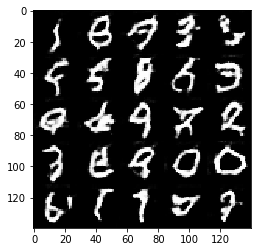

Epoch 1/2... Discriminator Loss: 0.5038... Generator Loss: 2.6217
Epoch 1/2... Discriminator Loss: 0.6004... Generator Loss: 1.3922
Epoch 1/2... Discriminator Loss: 0.5159... Generator Loss: 2.3592
Epoch 1/2... Discriminator Loss: 0.4993... Generator Loss: 1.6382
Epoch 1/2... Discriminator Loss: 0.4804... Generator Loss: 1.6476
Epoch 1/2... Discriminator Loss: 0.7398... Generator Loss: 1.1270
Epoch 1/2... Discriminator Loss: 0.3429... Generator Loss: 1.8347
Epoch 1/2... Discriminator Loss: 0.3242... Generator Loss: 2.9775
Epoch 1/2... Discriminator Loss: 0.3944... Generator Loss: 1.9804
Epoch 1/2... Discriminator Loss: 0.4845... Generator Loss: 1.2082


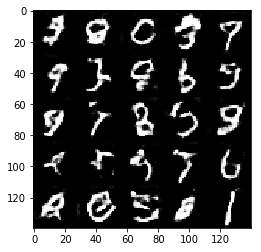

Epoch 1/2... Discriminator Loss: 0.4496... Generator Loss: 1.5703
Epoch 1/2... Discriminator Loss: 0.3238... Generator Loss: 2.0239
Epoch 1/2... Discriminator Loss: 0.7513... Generator Loss: 4.6936
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 1.2408
Epoch 1/2... Discriminator Loss: 0.6623... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 0.3153... Generator Loss: 2.8228
Epoch 1/2... Discriminator Loss: 0.3643... Generator Loss: 2.4807
Epoch 1/2... Discriminator Loss: 0.5006... Generator Loss: 2.2655
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 0.6561


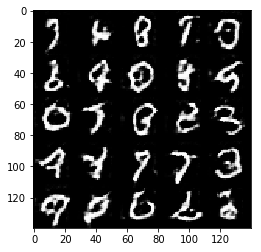

Epoch 1/2... Discriminator Loss: 0.4448... Generator Loss: 1.4329
Epoch 1/2... Discriminator Loss: 0.3552... Generator Loss: 1.6153
Epoch 1/2... Discriminator Loss: 0.2147... Generator Loss: 2.5873
Epoch 2/2... Discriminator Loss: 1.2562... Generator Loss: 7.4748
Epoch 2/2... Discriminator Loss: 0.4819... Generator Loss: 2.2856
Epoch 2/2... Discriminator Loss: 0.4206... Generator Loss: 1.6137
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 0.8627
Epoch 2/2... Discriminator Loss: 0.4336... Generator Loss: 2.2018
Epoch 2/2... Discriminator Loss: 0.5638... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 0.2447... Generator Loss: 3.3704


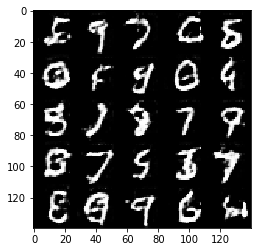

Epoch 2/2... Discriminator Loss: 0.6647... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 0.7047
Epoch 2/2... Discriminator Loss: 0.4312... Generator Loss: 1.5995
Epoch 2/2... Discriminator Loss: 0.4159... Generator Loss: 1.8042
Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 6.6649
Epoch 2/2... Discriminator Loss: 0.4216... Generator Loss: 1.9157
Epoch 2/2... Discriminator Loss: 0.4396... Generator Loss: 2.0019
Epoch 2/2... Discriminator Loss: 0.5511... Generator Loss: 1.7896
Epoch 2/2... Discriminator Loss: 0.5002... Generator Loss: 1.3811
Epoch 2/2... Discriminator Loss: 0.5455... Generator Loss: 1.2358


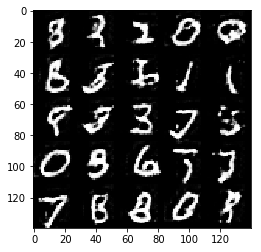

Epoch 2/2... Discriminator Loss: 0.3073... Generator Loss: 2.4475
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 5.4624
Epoch 2/2... Discriminator Loss: 0.5851... Generator Loss: 1.2222
Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 1.1722
Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.3658
Epoch 2/2... Discriminator Loss: 0.5320... Generator Loss: 3.6184
Epoch 2/2... Discriminator Loss: 0.5060... Generator Loss: 1.5280
Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 1.3235
Epoch 2/2... Discriminator Loss: 1.4169... Generator Loss: 0.5519


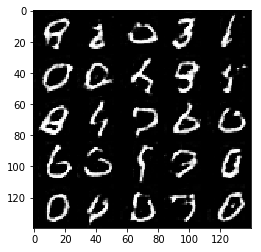

Epoch 2/2... Discriminator Loss: 0.3165... Generator Loss: 4.8940
Epoch 2/2... Discriminator Loss: 1.0678... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 0.1431... Generator Loss: 2.9706
Epoch 2/2... Discriminator Loss: 1.5288... Generator Loss: 8.9045
Epoch 2/2... Discriminator Loss: 0.4908... Generator Loss: 2.1931
Epoch 2/2... Discriminator Loss: 0.4165... Generator Loss: 1.8601
Epoch 2/2... Discriminator Loss: 0.5887... Generator Loss: 1.2968
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 1.6459
Epoch 2/2... Discriminator Loss: 0.7101... Generator Loss: 1.1117
Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 1.1654


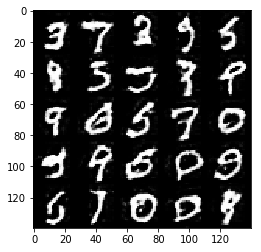

Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 0.7214
Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.3031
Epoch 2/2... Discriminator Loss: 0.8023... Generator Loss: 0.7769
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.0278
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 0.8684
Epoch 2/2... Discriminator Loss: 0.5351... Generator Loss: 1.5008
Epoch 2/2... Discriminator Loss: 0.7765... Generator Loss: 1.5321
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 0.8625
Epoch 2/2... Discriminator Loss: 0.7298... Generator Loss: 1.0010
Epoch 2/2... Discriminator Loss: 0.5269... Generator Loss: 1.5100


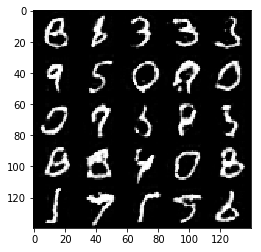

Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 0.3567... Generator Loss: 3.2565
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 1.6064
Epoch 2/2... Discriminator Loss: 0.3560... Generator Loss: 2.3853
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 0.9157
Epoch 2/2... Discriminator Loss: 0.5119... Generator Loss: 1.7801
Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 1.5620
Epoch 2/2... Discriminator Loss: 0.7133... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 0.5681... Generator Loss: 1.3376
Epoch 2/2... Discriminator Loss: 0.6962... Generator Loss: 1.0983


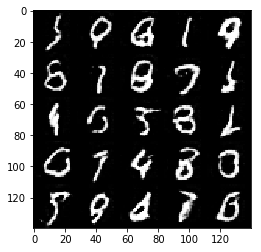

Epoch 2/2... Discriminator Loss: 0.4726... Generator Loss: 1.7769
Epoch 2/2... Discriminator Loss: 0.6108... Generator Loss: 1.4594
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 0.6737
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 1.0669
Epoch 2/2... Discriminator Loss: 0.3501... Generator Loss: 3.6892
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 0.3639... Generator Loss: 1.8178
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 0.4718... Generator Loss: 4.1034
Epoch 2/2... Discriminator Loss: 0.3606... Generator Loss: 2.2653


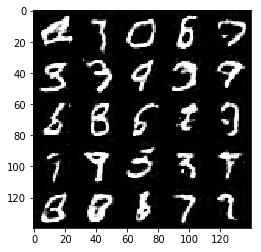

Epoch 2/2... Discriminator Loss: 0.4702... Generator Loss: 1.6125
Epoch 2/2... Discriminator Loss: 0.4157... Generator Loss: 1.9172
Epoch 2/2... Discriminator Loss: 0.5082... Generator Loss: 1.9815
Epoch 2/2... Discriminator Loss: 0.7035... Generator Loss: 1.1916
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 1.1473
Epoch 2/2... Discriminator Loss: 0.5679... Generator Loss: 1.6129
Epoch 2/2... Discriminator Loss: 0.3551... Generator Loss: 2.4281
Epoch 2/2... Discriminator Loss: 0.6486... Generator Loss: 1.6149
Epoch 2/2... Discriminator Loss: 0.3600... Generator Loss: 2.0413
Epoch 2/2... Discriminator Loss: 0.5559... Generator Loss: 1.7336


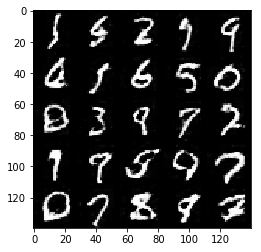

Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 6.7203
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 1.7686
Epoch 2/2... Discriminator Loss: 0.4685... Generator Loss: 2.1041
Epoch 2/2... Discriminator Loss: 0.4446... Generator Loss: 1.8635
Epoch 2/2... Discriminator Loss: 0.8300... Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 0.5317... Generator Loss: 1.6282
Epoch 2/2... Discriminator Loss: 0.6452... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 1.0483
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 1.0855
Epoch 2/2... Discriminator Loss: 0.6143... Generator Loss: 1.5058


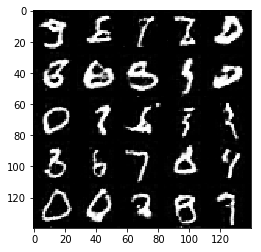

Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 1.2787
Epoch 2/2... Discriminator Loss: 0.5371... Generator Loss: 1.2384
Epoch 2/2... Discriminator Loss: 0.3387... Generator Loss: 3.1524
Epoch 2/2... Discriminator Loss: 0.4613... Generator Loss: 1.9796
Epoch 2/2... Discriminator Loss: 0.6649... Generator Loss: 1.1550
Epoch 2/2... Discriminator Loss: 0.4394... Generator Loss: 1.9732
Epoch 2/2... Discriminator Loss: 0.6588... Generator Loss: 1.2388


In [89]:
batch_size = 64
z_dim = 100
learning_rate =  0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
        

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6386... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.7112
Epoch 1/1... Discriminator Loss: 0.3097... Generator Loss: 2.9246
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 9.2130
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 4.0041
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 3.9542
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.7119
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 2.2262
Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 2.1090
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.9648


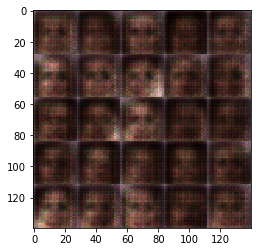

Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.9145
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 1.8822
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.8639
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 2.4573
Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 1.5562
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 1.6346
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 1.9502
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 2.5927
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 1.8932
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.0697


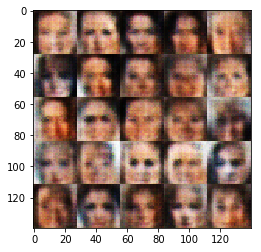

Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 1.4596
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 2.5015
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 1.3476
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.8112
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 2.5362
Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 2.9520
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 1.5988
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 2.5425
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.8517


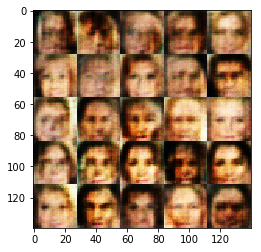

Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 2.0543
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 2.6420
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 3.9157
Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.5702
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.2875
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.6366
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 2.0016
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 1.6348


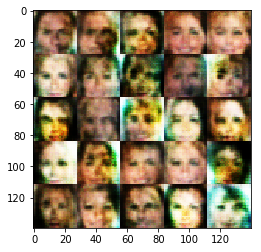

Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 5.7027
Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 2.2587
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 0.2494... Generator Loss: 4.4516
Epoch 1/1... Discriminator Loss: 0.2638... Generator Loss: 2.2320
Epoch 1/1... Discriminator Loss: 0.5745... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 1.3018
Epoch 1/1... Discriminator Loss: 0.2581... Generator Loss: 3.6846
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 2.3460
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 1.2814


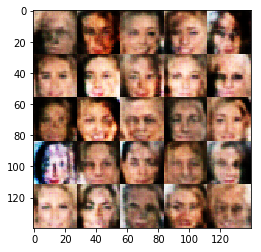

Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 3.5803
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 1.6937
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 2.5987
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 4.3006
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 3.6691
Epoch 1/1... Discriminator Loss: 0.1975... Generator Loss: 4.5105
Epoch 1/1... Discriminator Loss: 0.2012... Generator Loss: 2.9034
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 0.2198... Generator Loss: 2.1392


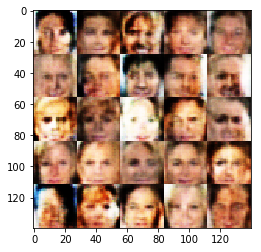

Epoch 1/1... Discriminator Loss: 0.0801... Generator Loss: 3.2025
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 5.9393
Epoch 1/1... Discriminator Loss: 0.1766... Generator Loss: 5.6080
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 5.5592
Epoch 1/1... Discriminator Loss: 0.1914... Generator Loss: 3.6582
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 7.0799
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 7.6941
Epoch 1/1... Discriminator Loss: 0.4799... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 0.2281... Generator Loss: 1.9176
Epoch 1/1... Discriminator Loss: 0.1456... Generator Loss: 3.1992


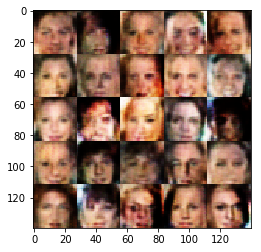

Epoch 1/1... Discriminator Loss: 0.1678... Generator Loss: 2.6167
Epoch 1/1... Discriminator Loss: 0.2774... Generator Loss: 1.7347
Epoch 1/1... Discriminator Loss: 0.2439... Generator Loss: 3.0344
Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 1.9367
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.9836
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 1.7202
Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 1.8814
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 1.8178
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 2.3545
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 1.8251


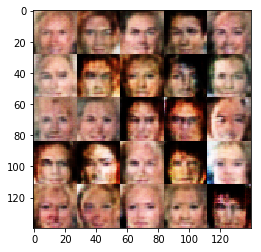

Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 1.8578
Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 2.1221
Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 2.0926
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 1.7081
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 0.4633... Generator Loss: 3.1705
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 2.3629


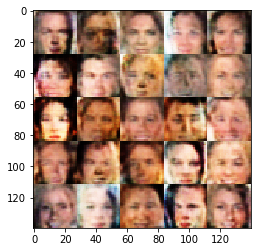

Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 2.7938
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 1.6151
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 2.2619
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 3.9964
Epoch 1/1... Discriminator Loss: 0.0976... Generator Loss: 3.9597
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 3.8825
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 2.0613
Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 2.0264
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.5019


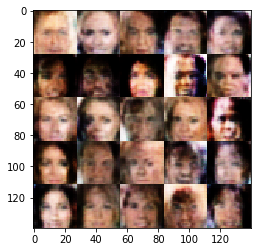

Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 3.8165
Epoch 1/1... Discriminator Loss: 0.2553... Generator Loss: 2.8865
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 0.2111... Generator Loss: 2.8707
Epoch 1/1... Discriminator Loss: 0.2763... Generator Loss: 2.7432
Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 1.7694
Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 2.4912
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.4969


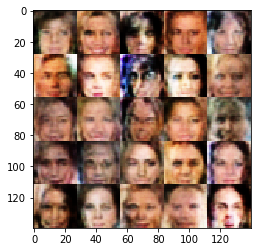

Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 1.5580
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 1.9973
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 3.1519
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 1.5374
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 1.8142
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 2.6998
Epoch 1/1... Discriminator Loss: 0.7903... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 2.5562


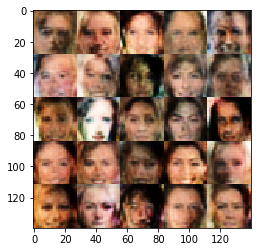

Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 3.5661
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 1.8974
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 1.9111
Epoch 1/1... Discriminator Loss: 0.4737... Generator Loss: 2.1139
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 1.9613
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 1.0899


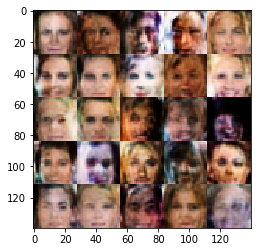

Epoch 1/1... Discriminator Loss: 0.3008... Generator Loss: 2.5777
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 5.2093
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 1.6769
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 4.3186
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 6.6806
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 1.7419
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.8883
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 2.4073


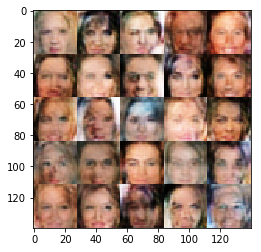

Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 1.9828
Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 2.0733
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 1.7575
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 1.2591
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 1.7459
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.6193
Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 2.4029


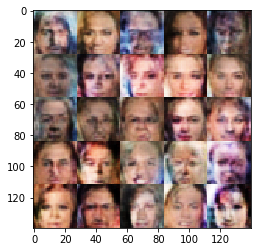

Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 2.5455
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 3.7272
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 2.7835
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 6.3216
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 1.4854
Epoch 1/1... Discriminator Loss: 0.4556... Generator Loss: 2.1232


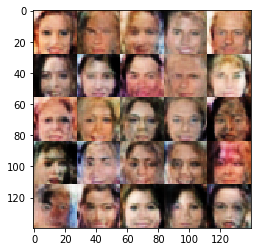

Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 2.8994
Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 2.9670
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 2.9267
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 3.5278
Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 1.8951
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 1.4576
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 2.5572
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 2.3213


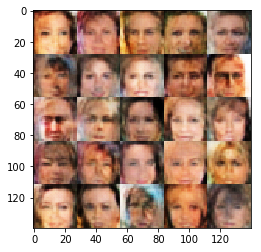

Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 2.7445
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 3.9962
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 2.5186
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 1.8930
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.5557
Epoch 1/1... Discriminator Loss: 0.3661... Generator Loss: 2.6194
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 2.8288


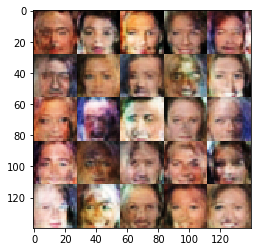

Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 3.6282
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 1.7839
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 1.7883
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.1317
Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 2.1947
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 1.9004


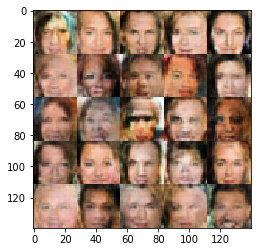

Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 2.4763
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 1.7611
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 3.5484
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 2.0484
Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 2.5825
Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 2.6813
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 3.1781


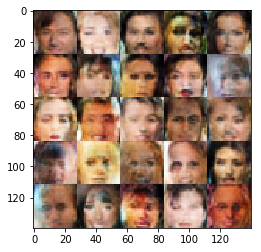

Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 3.4181
Epoch 1/1... Discriminator Loss: 0.4119... Generator Loss: 3.2943
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 2.1272
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 2.1867
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 2.2181
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.6278


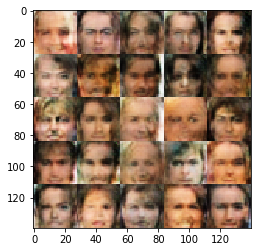

Epoch 1/1... Discriminator Loss: 0.5712... Generator Loss: 2.4690
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 1.4353
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 1.7753
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 1.6359
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 2.0598
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 2.3119
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 1.8286
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 1.3861
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 0.8567


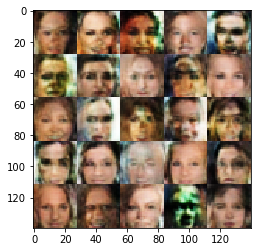

Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.4649
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 1.9210
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 4.2392
Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 1.7148
Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 1.3163
Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 1.5972


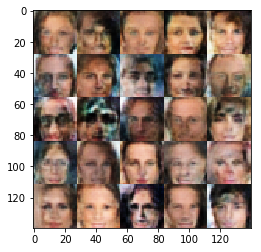

Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 1.9595
Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 1.4343
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.8261
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 0.5377... Generator Loss: 1.7385
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 1.5677
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 2.5217
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 1.2249


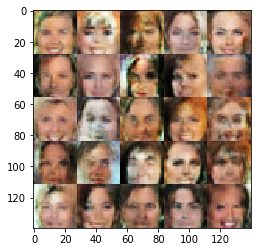

Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 2.2340
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 1.7280
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 1.9755
Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 2.0328
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 1.9664
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.3600
Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 1.6876
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 1.5322


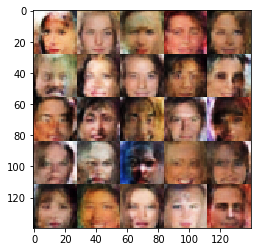

Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 2.2172
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 0.5388... Generator Loss: 1.6530
Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 1.7927
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 1.5494
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 1.4359
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 2.0053
Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 1.6908
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 4.6883


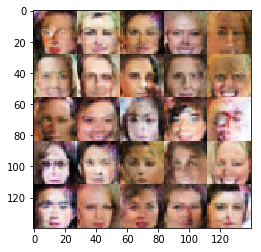

Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 1.7306
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 1.5738
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 1.6035
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 1.3673
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 1.9597
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 1.3432
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 2.0620
Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 1.8906
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 1.1152


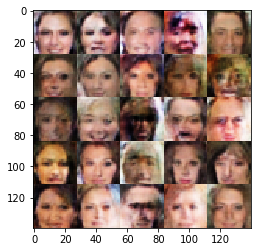

Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 2.5485
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 2.3934
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 1.9745
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 2.5704
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 1.3702


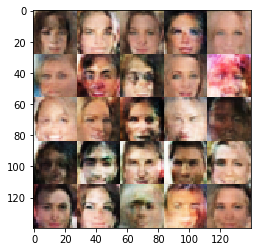

Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 1.7980
Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 2.5170
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 6.0333
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.1573
Epoch 1/1... Discriminator Loss: 0.4439... Generator Loss: 2.6759
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 1.8428
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 2.2021
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 1.8240
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 1.9743


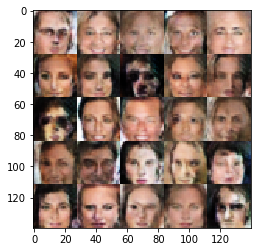

Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 1.8804
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 3.6980
Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 3.5194
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 1.8913
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 1.4287
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 1.8985
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 0.5480... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 1.4171
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 1.0912


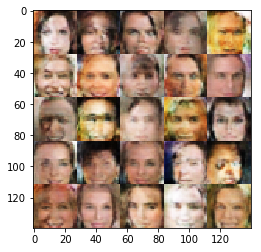

Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 1.3033
Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 2.3548
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 0.2316... Generator Loss: 2.8552
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.2096
Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 1.5940
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 1.8174


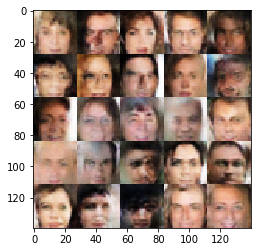

Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 1.5625
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 3.8870
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 7.0571
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.3643
Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 2.3876
Epoch 1/1... Discriminator Loss: 0.3268... Generator Loss: 3.7559


In [90]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.